In [4]:
!pip install mysql-connector-python==8.0.29

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 25.2/25.2 MB 55.6 MB/s eta 0:00:00


In [2]:
!pip install imbalanced-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample
import statsmodels.api as sm

import imblearn
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from collections import Counter
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
import joblib

from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import mysql.connector

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [6]:
pd.set_option('display.max_columns', 500)

# Load Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
path = '/content/drive/MyDrive/Capstone/data_final/model_ready_df.feather'
data = pd.read_feather(path)


In [ ]:
data = data.drop('temp_id',axis=1)

# SMOTE Rebalancing and Split Into Train and Test Sets

We have a dataset with a 2:100 class distribution, we first apply oversampling to increase the ratio to 1:10 by duplicating examples from the minority class, then apply undersampling to further improve the ratio to 1:2 by deleting examples from the majority class.

In [ ]:
scaler = StandardScaler()

def resample_train_test(df):
  #split the data into train and test sets
  train_data, test_data = train_test_split(df, test_size=0.2, 
                                                      random_state=123)

  X_train = train_data.drop(['isCompleted','latestInteraction'], axis=1)
  y_train = train_data['latestInteraction']

  X_test = test_data.drop(['isCompleted','latestInteraction'], axis=1)
  y_test = test_data['latestInteraction']

  # Standardize predictors
  X_train = scaler.fit_transform(X_train)
  X_test = scaler.transform(X_test)

  # summarize class distribution
  counter = Counter(y_train)
  print(counter)

  # define pipeline
  over = SMOTE(sampling_strategy=0.5)
  under = RandomUnderSampler(sampling_strategy=0.2)
  steps = [('o', over), ('u', under)]
  pipeline = Pipeline(steps=steps)

  # transform the dataset
  X_train,y_train = pipeline.fit_resample(X_train,y_train)

  # summarize the new class distribution
  counter = Counter(y_train)
  print(counter)

  return X_train, y_train, X_test, y_test

In [ ]:
#X_train, y_train, X_test, y_test = resample_train_test(df3)

Counter({0: 1150587, 1: 21605})
Counter({0: 460234, 1: 230117})


In [ ]:
scaler = StandardScaler()

def resample_method(data, method='smote'):
    '''
    PARAMETERS: Dataframe and method to resample
    RETURNS: Resampled dataframe
    '''
    
    train_data, test_data = train_test_split(data, test_size=0.2, random_state=123)

    if method == 'smote_log' :

        X_train = train_data.drop(['isCompleted','latestInteraction'], axis=1)
        y_train = train_data['latestInteraction']

        X_test = test_data.drop(['isCompleted','latestInteraction'], axis=1)
        y_test = test_data['latestInteraction']

        # Standardize predictors
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)

        over = SMOTE(sampling_strategy=0.2, random_state=123)
        under = RandomUnderSampler(sampling_strategy=1, random_state=123)
        steps = [('o', over), ('u', under)]
        pipeline = Pipeline(steps=steps)

        # transform the dataset
        X_train,y_train = pipeline.fit_resample(X_train,y_train)

        print('Resampled dataset shape %s' % Counter(y_train))

        return X_train, y_train, X_test, y_test
    
    elif method == 'smote' :

        X_train = train_data.drop(['isCompleted','latestInteraction'], axis=1)
        y_train = train_data['latestInteraction']

        X_test = test_data.drop(['isCompleted','latestInteraction'], axis=1)
        y_test = test_data['latestInteraction']

        over = SMOTE(sampling_strategy=0.2, random_state=123)
        under = RandomUnderSampler(sampling_strategy=1, random_state=123)
        steps = [('o', over), ('u', under)]
        pipeline = Pipeline(steps=steps)

        # transform the dataset
        X_train,y_train = pipeline.fit_resample(X_train,y_train)

        print('Resampled dataset shape %s' % Counter(y_train))

        return X_train, y_train, X_test, y_test

    # downsample the majority class
    elif method == 'downsample_log':
        # separate minority and majority classes
        rejected = train_data[train_data.latestInteraction==0]
        accepted = train_data[train_data.latestInteraction==1]

        # downsample majority
        rejected_downsampled = resample(rejected, replace=False, n_samples=2*len(accepted), random_state=123)

        # combine minority and downsampled majority
        train_downsampled = pd.concat([rejected_downsampled, accepted])

        print('Resampled dataset shape %s' % Counter(train_downsampled.latestInteraction))

        X_train = train_downsampled.drop(['isCompleted','latestInteraction'], axis=1)
        y_train = train_downsampled['latestInteraction']

        X_test = test_data.drop(['isCompleted','latestInteraction'], axis=1)
        y_test = test_data['latestInteraction']

        # Standardize predictors
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)

        return X_train, y_train, X_test, y_test

    # downsample the majority class
    elif method == 'downsample':
        # separate minority and majority classes
        rejected = train_data[train_data.latestInteraction==0]
        accepted = train_data[train_data.latestInteraction==1]

        # downsample majority
        rejected_downsampled = resample(rejected, replace=False, n_samples=2*len(accepted), random_state=123)

        # combine minority and downsampled majority
        train_downsampled = pd.concat([rejected_downsampled, accepted])

        print('Resampled dataset shape %s' % Counter(train_downsampled.latestInteraction))

        X_train = train_downsampled.drop(['isCompleted','latestInteraction'], axis=1)
        y_train = train_downsampled['latestInteraction']

        X_test = test_data.drop(['isCompleted','latestInteraction'], axis=1)
        y_test = test_data['latestInteraction']

        return X_train, y_train, X_test, y_test

    else:
        print('Please enter a valid resampling method')

        

In [ ]:
# smote 
X_train_smote, y_train_smote, X_test_smote, y_test_smote = resample_method(data, method='smote')

Resampled dataset shape Counter({0: 272124, 1: 272124})


In [ ]:
# downsample
X_train_ds, y_train_ds, X_test_ds, y_test_ds = resample_method(data, method='downsample')

Resampled dataset shape Counter({0: 42732, 1: 21366})


In [ ]:
# log smote
X_train_smote_log, y_train_smote_log, X_test_smote_log, y_test_smote_log = resample_method(data, method='smote_log')

# log downsample
X_train_ds_log, y_train_ds_log, X_test_ds_log, y_test_ds_log = resample_method(data, method='downsample_log')

Resampled dataset shape Counter({0: 272124, 1: 272124})
Resampled dataset shape Counter({0: 42732, 1: 21366})


# Training Model

In [ ]:
# Model 
def model(model, X_train, y_train, X_test, y_test,threshold):
    '''
    PARAMETERS: Model, X_train, y_train, X_test, y_test
    RETURNS: Model, y_pred, y_pred_prob
    '''
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_pred_prob = model.predict_proba(X_test)
    # Define threshold 0.35
    y_pred = [1 if prob > threshold else 0 for prob in y_pred_prob[:,1]]
    y_pred_prob = y_pred_prob*(0.5/threshold)

    print('Train Accuracy: ', model.score(X_train, y_train))
    print('Test Accuracy: ', model.score(X_test, y_test))
    print()
    print('ROC AUC: ', metrics.roc_auc_score(y_test, y_pred_prob[:,1]))
    print()
    print('Confusion Matrix: \n', confusion_matrix(y_test, y_pred))
    print()
    print('Classification Report: \n', classification_report(y_test, y_pred))
    
    return model, y_pred, y_pred_prob

## Logistic Regression Model

Train Accuracy: 97.3%

In [ ]:
# randomizedsearchcv
log_ft = LogisticRegression()

param_grid = {'C': np.logspace(-3,3,20), 'penalty': ['l1', 'l2'], 'solver': ['liblinear', 'saga', 'lbfgs', 'newton-cg']}

logreg_cv = RandomizedSearchCV(log_ft, param_grid, cv=5, scoring='f1', n_jobs=-1, random_state=123)

logreg_cv.fit(X_train_ds_log, y_train_ds_log)

print('Best parameters: ', logreg_cv.best_params_)
print('Best score: ', logreg_cv.best_score_)

print(classification_report(y_test_smote_log, logreg_cv.predict(X_test_smote_log)))

Best parameters:  {'solver': 'saga', 'penalty': 'l1', 'C': 233.57214690901213}
Best score:  0.052262696087741735
              precision    recall  f1-score   support

           0       0.98      0.98      0.98    340087
           1       0.03      0.03      0.03      5411

    accuracy                           0.97    345498
   macro avg       0.51      0.51      0.51    345498
weighted avg       0.97      0.97      0.97    345498



In [ ]:
logreg_model = LogisticRegression(**logreg_cv.best_params_)
print('Logistic Regression with SMOTE')
logreg_smote, logreg_y_pred_smote, logreg_y_pred_prob_smote = model(logreg_model, X_train_smote_log, y_train_smote_log, X_test_smote_log, y_test_smote_log,0.32774999999999693)
print()
print('Logistic Regression with Downsample')
logreg_ds, logreg_y_pred_ds, logreg_y_pred_prob_ds = model(logreg_model, X_train_ds_log, y_train_ds_log, X_test_ds_log, y_test_ds_log,0.32774999999999693)

Logistic Regression with SMOTE
Train Accuracy:  0.562519292675398
Test Accuracy:  0.5911872138188933

ROC AUC:  0.5912501233140004

Confusion Matrix: 
 [[ 17488 322599]
 [    74   5337]]

Classification Report: 
               precision    recall  f1-score   support

           0       1.00      0.05      0.10    340087
           1       0.02      0.99      0.03      5411

    accuracy                           0.07    345498
   macro avg       0.51      0.52      0.06    345498
weighted avg       0.98      0.07      0.10    345498


Logistic Regression with Downsample
Train Accuracy:  0.666729071109863
Test Accuracy:  0.9706915814273889

ROC AUC:  0.5911462365720753

Confusion Matrix: 
 [[193276 146811]
 [  2420   2991]]

Classification Report: 
               precision    recall  f1-score   support

           0       0.99      0.57      0.72    340087
           1       0.02      0.55      0.04      5411

    accuracy                           0.57    345498
   macro avg       0.50

In [ ]:
joblib.dump(logreg_smote, "logreg_smote_model.joblib")

['logreg_smote_model.joblib']

In [ ]:
joblib.dump(logreg_ds, "logreg_ds_model.joblib")

['logreg_ds_model.joblib']

## XGBoost

Test Accuracy: 98.42%

In [ ]:
import xgboost
from xgboost import XGBClassifier

In [ ]:
#instantiating the model
XGB_ft = XGBClassifier()

params = {
    'max_depth': [5,10,15,20,25,30],
    'n_estimators': [100,200,300,400,500,600],
    'learning_rate': [0.1, 0.01, 0.05]
}

# Initialize the GridSearchCV
XGB_cv=RandomizedSearchCV(XGB_ft,params,cv=5,scoring = 'f1',n_jobs=-1,random_state=123)

#XGB_cv.fit(X_train, y_train)
XGB_cv.fit(X_train_smote, y_train_smote)

print('Best parameters: ', XGB_cv.best_params_)
print('Best score: ', XGB_cv.best_score_)

print(classification_report(y_test_smote, XGB_cv.predict(X_test_smote)))

Best parameters:  {'n_estimators': 200, 'max_depth': 30, 'learning_rate': 0.1}
Best score:  0.8557846940371798
              precision    recall  f1-score   support

           0       0.99      0.85      0.91    340087
           1       0.02      0.21      0.04      5411

    accuracy                           0.84    345498
   macro avg       0.50      0.53      0.47    345498
weighted avg       0.97      0.84      0.90    345498



In [ ]:
xgb_mod = XGBClassifier(**XGB_cv.best_params_)
print('XGBoost with SMOTE')
xgb_smote, xgb_y_pred_smote, xgb_y_pred_prob_smote = model(xgb_mod, X_train_smote, y_train_smote, X_test_smote, y_test_smote)
print()
print('XGBoost with Downsample')
xgb_ds, xgb_y_pred_ds, xgb_y_pred_prob_ds = model(xgb_mod, X_train_ds, y_train_ds, X_test_ds, y_test_ds)

XGBoost with SMOTE
Train Accuracy:  0.8797055753994503
Test Accuracy:  0.8351538937996746

ROC AUC:  0.5767673699670695

Confusion Matrix: 
 [[287431  52656]
 [  4298   1113]]

Classification Report: 
               precision    recall  f1-score   support

           0       0.99      0.85      0.91    340087
           1       0.02      0.21      0.04      5411

    accuracy                           0.84    345498
   macro avg       0.50      0.53      0.47    345498
weighted avg       0.97      0.84      0.90    345498


XGBoost with Downsample
Train Accuracy:  0.8250647446098163
Test Accuracy:  0.8186907015380697

ROC AUC:  0.5779040310761535

Confusion Matrix: 
 [[281604  58483]
 [  4159   1252]]

Classification Report: 
               precision    recall  f1-score   support

           0       0.99      0.83      0.90    340087
           1       0.02      0.23      0.04      5411

    accuracy                           0.82    345498
   macro avg       0.50      0.53      0.47  

In [ ]:
joblib.dump(xgb_smote, "xgb_smote_model.joblib")

['xgb_smote_model.joblib']

In [ ]:
joblib.dump(xgb_ds, "xgb_ds_model.joblib")

['xgb_ds_model.joblib']

## Random Forest

Test Accuracy: 95.72%

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
#create a Random Forest model
rf_ft = RandomForestClassifier()

# Setting up the hyperparameters
params={
    'n_estimators':[100,200,300,400,500,600],
    'max_depth':[5,10,15,20,25,30],
    }

# Initialize the GridSearchCV
rf_cv = RandomizedSearchCV(rf_ft,params,cv=5,scoring = 'f1',n_jobs=-1,random_state=123)

rf_cv.fit(X_train_smote, y_train_smote)

print('Best parameters: ', rf_cv.best_params_)
print('Best score: ', rf_cv.best_score_)

print(classification_report(y_test_smote, rf_cv.predict(X_test_smote)))

Best parameters:  {'n_estimators': 300, 'max_depth': 30}
Best score:  0.8364567436530794
              precision    recall  f1-score   support

           0       0.99      0.81      0.89    340087
           1       0.02      0.26      0.04      5411

    accuracy                           0.80    345498
   macro avg       0.50      0.54      0.47    345498
weighted avg       0.97      0.80      0.88    345498



In [ ]:
rf_mod = RandomForestClassifier(**rf_cv.best_params_)
print('Random Forest with SMOTE')
rf_smote, rf_y_pred_smote, rf_y_pred_prob_smote = model(rf_mod, X_train_smote, y_train_smote, X_test_smote, y_test_smote)
print()
print('Random Forest with Downsample')
rf_ds, rf_y_pred_ds, rf_y_pred_prob_ds = model(rf_mod, X_train_ds, y_train_ds, X_test_ds, y_test_ds)

Random Forest with SMOTE
Train Accuracy:  0.8634942158721759
Test Accuracy:  0.8033418427892491

ROC AUC:  0.5749187564389397

Confusion Matrix: 
 [[276140  63947]
 [  3998   1413]]

Classification Report: 
               precision    recall  f1-score   support

           0       0.99      0.81      0.89    340087
           1       0.02      0.26      0.04      5411

    accuracy                           0.80    345498
   macro avg       0.50      0.54      0.47    345498
weighted avg       0.97      0.80      0.88    345498


Random Forest with Downsample
Train Accuracy:  0.8524914973946145
Test Accuracy:  0.7906181801341832

ROC AUC:  0.569150441337193

Confusion Matrix: 
 [[271799  68288]
 [  4053   1358]]

Classification Report: 
               precision    recall  f1-score   support

           0       0.99      0.80      0.88    340087
           1       0.02      0.25      0.04      5411

    accuracy                           0.79    345498
   macro avg       0.50      0.53 

In [ ]:
joblib.dump(rf_smote, "rf_smote_model.joblib")

['rf_smote_model.joblib']

In [ ]:
joblib.dump(rf_ds, "rf_ds_model.joblib")

['rf_ds_model.joblib']

## MLP Classifier

In [ ]:
from sklearn.neural_network import MLPClassifier
from scipy.stats import randint as sp_randint
from random import uniform

In [ ]:
mlp_ft = MLPClassifier()

parameter_space = {
    'hidden_layer_sizes': [(sp_randint.rvs(100,600,1),sp_randint.rvs(100,600,1),), 
                                          (sp_randint.rvs(100,600,1),)],
    'activation': ['tanh', 'relu', 'logistic'],
    'solver': ['sgd', 'adam', 'lbfgs'],
    'alpha': [0.001,0.01,0.1,0.5],
    'learning_rate': ['constant','adaptive']}

MLP_cv = RandomizedSearchCV(mlp_ft, parameter_space,scoring = 'f1', n_jobs=-1, cv=5,verbose = 1)

MLP_cv.fit(X_train_smote, y_train_smote)

print('Best parameters: ', MLP_cv.best_params_)
print('Best score: ', MLP_cv.best_score_)

print(classification_report(y_test_smote, MLP_cv.predict(X_test_smote)))

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best parameters:  {'solver': 'adam', 'learning_rate': 'adaptive', 'hidden_layer_sizes': (337,), 'alpha': 0.001, 'activation': 'relu'}
Best score:  0.6590575800735597
              precision    recall  f1-score   support

           0       0.99      0.61      0.75    340087
           1       0.02      0.45      0.03      5411

    accuracy                           0.60    345498
   macro avg       0.50      0.53      0.39    345498
weighted avg       0.97      0.60      0.74    345498



In [ ]:
joblib.dump(MLP_cv, "mlp_cv.joblib")

In [ ]:
mlp_mod = MLPClassifier(**MLP_cv.best_params_)
print('MLP with SMOTE')
mlp_smote, mlp_y_pred_smote, mlp_y_pred_prob_smote = model(mlp_mod, X_train_smote, y_train_smote, X_test_smote, y_test_smote)
print()
print('MLP with Downsample')
mlp_ds, mlp_y_pred_ds, mlp_y_pred_prob_ds = model(mlp_mod, X_train_ds, y_train_ds, X_test_ds, y_test_ds)

MLP with SMOTE
Train Accuracy:  0.6133729476268172
Test Accuracy:  0.5384922633416113

ROC AUC:  0.5743775760354388

Confusion Matrix: 
 [[182973 157114]
 [  2336   3075]]

Classification Report: 
               precision    recall  f1-score   support

           0       0.99      0.54      0.70    340087
           1       0.02      0.57      0.04      5411

    accuracy                           0.54    345498
   macro avg       0.50      0.55      0.37    345498
weighted avg       0.97      0.54      0.69    345498


MLP with Downsample
Train Accuracy:  0.6502542981060252
Test Accuracy:  0.8960746516622383

ROC AUC:  0.5884553926124018

Confusion Matrix: 
 [[308903  31184]
 [  4722    689]]

Classification Report: 
               precision    recall  f1-score   support

           0       0.98      0.91      0.95    340087
           1       0.02      0.13      0.04      5411

    accuracy                           0.90    345498
   macro avg       0.50      0.52      0.49    345498

In [ ]:
joblib.dump(mlp_smote, "mlp_smote_model.joblib")

['mlp_smote_model.joblib']

In [ ]:
joblib.dump(mlp_ds, "mlp_ds_model.joblib")

['mlp_ds_model.joblib']

## Model Results

In [ ]:
def plot_roc_curve(models, y_preds, y_preds_probs, y_test, name='smote'):
    '''
    PARAMETERS: List of models, List of y_preds, List of y_preds_probs, y_test
    RETURNS: ROC Curve
    '''
    plt.figure(figsize=(10,8))
    plt.plot([0, 1], [0, 1], linestyle='--', label='Baseline')
    for i in range(len(models)):
        fpr, tpr, thresholds = roc_curve(y_test, y_preds_probs[i][:,1])
        plt.plot(fpr, tpr, label=models[i] + ' | ' + 'AUC: ' + str(round(roc_auc_score(y_test, y_preds_probs[i][:,1]), 3)))
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve' + ' ' + name)
    plt.legend()
    plt.show()

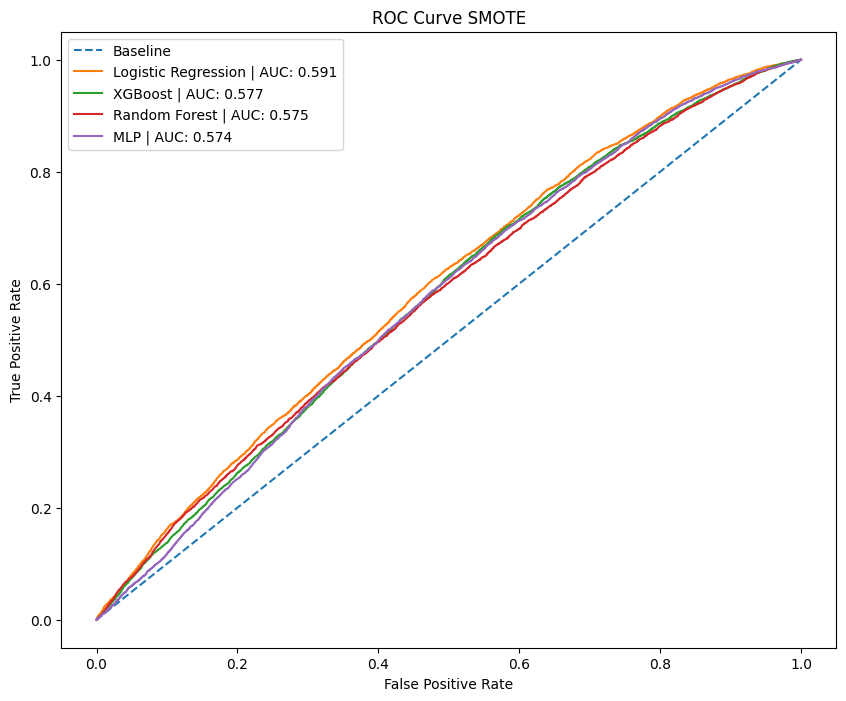

In [ ]:
# SMOTE ROC Curve
models_smote = ['Logistic Regression', 'XGBoost', 'Random Forest', 'MLP']
y_preds_smote = [logreg_y_pred_smote, xgb_y_pred_smote, rf_y_pred_smote, mlp_y_pred_smote]
y_preds_probs_smote = [logreg_y_pred_prob_smote, xgb_y_pred_prob_smote, rf_y_pred_prob_smote, mlp_y_pred_prob_smote]

plot_roc_curve(models_smote, y_preds_smote, y_preds_probs_smote, y_test_smote, name='SMOTE')

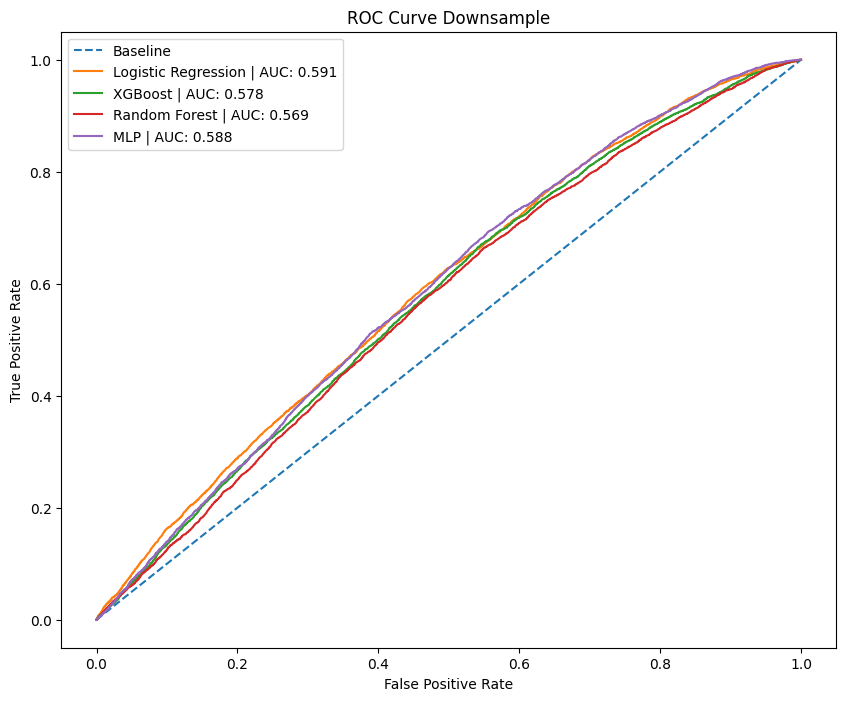

In [ ]:
# Downsample ROC Curve
models_ds = ['Logistic Regression', 'XGBoost', 'Random Forest', 'MLP']
y_preds_ds = [logreg_y_pred_ds, xgb_y_pred_ds, rf_y_pred_ds, mlp_y_pred_ds]
y_preds_probs_ds = [logreg_y_pred_prob_ds, xgb_y_pred_prob_ds, rf_y_pred_prob_ds, mlp_y_pred_prob_ds]

plot_roc_curve(models_ds, y_preds_ds, y_preds_probs_ds, y_test_ds, name='Downsample')

# Quick-Load Models

Logistic Regression

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

path_ds = '/content/drive/MyDrive/Capstone/model_files/logreg_ds_model.joblib'
path_smote = '/content/drive/MyDrive/Capstone/model_files/logreg_smote_model.joblib'
logreg_ds = joblib.load(path_ds)
logreg_smote = joblib.load(path_smote)


Mounted at /content/drive


RF Models

In [ ]:
path_ds = '/content/drive/MyDrive/Capstone/model_files/rf_ds_model.joblib'
path_smote = '/content/drive/MyDrive/Capstone/model_files/rf_smote_model.joblib'
rf_ds = joblib.load(path_ds)
rf_smote = joblib.load(path_smote)


XGBoost

In [ ]:
path_ds = '/content/drive/MyDrive/Capstone/model_files/xgb_ds_model.joblib'
path_smote = '/content/drive/MyDrive/Capstone/model_files/xgb_smote_model.joblib'
xgb_ds = joblib.load(path_ds)
xgb_smote = joblib.load(path_smote)


MLP

In [ ]:
path_ds = '/content/drive/MyDrive/Capstone/model_files/mlp_ds_model.joblib'
path_smote = '/content/drive/MyDrive/Capstone/model_files/mlp_smote_model.joblib'
mlp_ds = joblib.load(path_ds)
mlp_smote = joblib.load(path_smote)

# Thresholds

In [ ]:
thresholds = np.arange(0.3, 0.5, 0.00025)
true_rejected_rates = []
true_accepted_rates = []

for threshold in thresholds:
    # Call model function
    logreg_ds, logreg_y_pred_ds, logreg_y_pred_prob_ds,cm = model(logreg_model, X_train_ds_log, y_train_ds_log, X_test_ds_log, y_test_ds_log,threshold)
    
    # Calculate true rejected rate
    true_rejected_rate = cm[0][0]/sum(cm[0])
    
    # Calculate true accepted rate
    true_accepted_rate = cm[1][1]/sum(cm[1])
    
    # Append true rejected rate
    true_rejected_rates.append(true_rejected_rate)
    
    # Append true accepted rate
    true_accepted_rates.append(true_accepted_rate)


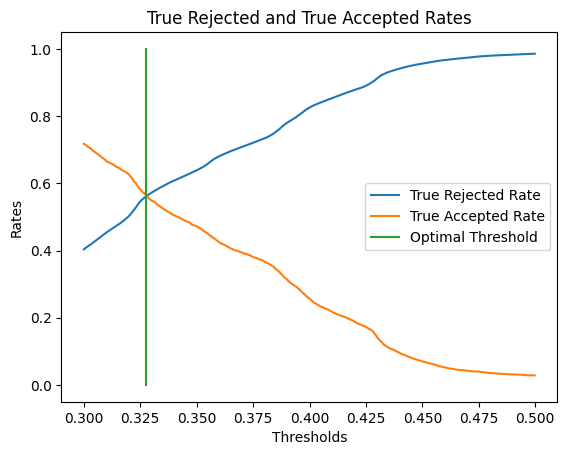

In [ ]:
# Calculate the threshold where true rejected rate and true accepted rate are equal
optimal_threshold = thresholds[np.argmin(np.abs(np.array(true_rejected_rates) - np.array(true_accepted_rates)))]

# Plot true rejected rate and true accepted rate
plt.plot(thresholds, true_rejected_rates, label='True Rejected Rate')
plt.plot(thresholds, true_accepted_rates, label='True Accepted Rate')
plt.plot([optimal_threshold, optimal_threshold], [0, 1], label='Optimal Threshold')
plt.xlabel('Thresholds')
plt.ylabel('Rates')
plt.title('True Rejected and True Accepted Rates')
plt.legend()
plt.show()

In [ ]:
optimal_threshold

0.32774999999999693

In [ ]:

temp = y_test_smote_log.reset_index(drop=True)


In [ ]:
accepted_probs = []
for index, val in enumerate(temp):
    if val == 1:
        accepted_probs.append(logreg_y_pred_prob_ds[index][1])


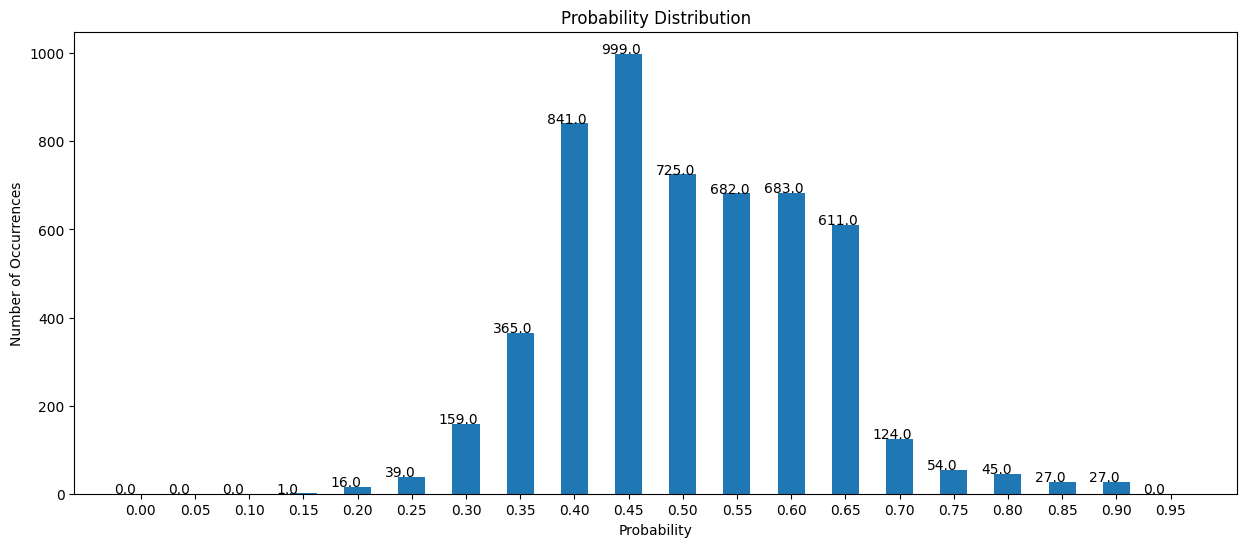

In [ ]:
bins = np.arange(0.0, 1.0, 0.05)
bin_counts = np.zeros(20)

for prob in accepted_probs:
    for i in range(len(bins)-1):
        if prob > bins[i] and prob <= bins[i+1]:
            bin_counts[i] += 1

plt.figure(figsize=(15,6))       
plt.bar(bins, bin_counts,width =0.025)
plt.xticks(bins)
plt.xlabel("Probability")
plt.ylabel("Number of Occurrences")
plt.title("Probability Distribution")

for i in range(len(bin_counts)):
    plt.text(bins[i]-0.025, bin_counts[i] + 0.5, str(bin_counts[i]))
    
plt.show()

# Test (If you add __ dollars to your offer, the probability the trade is accepted is:"

## Initial Offer

In [ ]:
data[data['latestInteraction']=='accepted'].tail(50)

,isCompleted,latestInteraction,id_x,cashAmount_x,currency_x,minMarketPrice_x,tradeWillingness_x,wasPreviouslyAuthenticated_x,size_x,hasBox_x,boxStatus_x,hasAccessories_x,id_y,cashAmount_y,currency_y,minMarketPrice_y,tradeWillingness_y,wasPreviouslyAuthenticated_y,size_y,hasBox_y,boxStatus_y,hasAccessories_y,interactionId,givingShoe_x,receivingShoe_y
6387148,0,accepted,clb3b8em9052s08jscrlrglzo,0.0,USD,380,1,1,9.0,0,originalGoodCondition,1,clb3b8eo7053308js5zjpbyxm,0.0,USD,398,1,0,8.5,0,originalGoodCondition,1,clb3b8fg9138208md7ygfhugl,cl70pwo0b0ovp09mi8msk04eb,cl70pwo0b0ovp09mi8msk04eb
6387612,0,accepted,clb3c0r020erm08l0fm344d3h,0.0,USD,433,1,1,13.0,0,originalGoodCondition,1,clb3c0qxu0erb08l0b7z69nfm,35.0,USD,764,2,0,13.0,0,originalGoodCondition,1,clb3c0s3t1pcw08mdgl8c47vq,cl6giwqxh0wvi09l7f1bw56if,ckdguxjp2017c07jx15obapix
6387613,0,accepted,clb3c0r020erm08l0fm344d3h,0.0,USD,324,1,1,13.0,0,originalGoodCondition,1,clb3c0qxu0erb08l0b7z69nfm,35.0,USD,764,2,0,13.0,0,originalGoodCondition,1,clb3c0s3t1pcw08mdgl8c47vq,cl4rdvmvf0ztu09miht8nhzn8,ckdguxjp2017c07jx15obapix
6389814,0,accepted,clb3ngadp0d4n08lc3jpdc7jc,0.0,USD,398,2,1,8.5,0,originalGoodCondition,1,clb3nga990d3w08lcdatn72o8,0.0,USD,389,1,0,8.5,0,originalGoodCondition,1,clb3ngbeg0d6708lc3mij47md,cl70pwo0b0ovp09mi8msk04eb,cl6giwqxh0wvi09l7f1bw56if
6389815,0,accepted,clb3ngadp0d4n08lc3jpdc7jc,0.0,USD,398,2,1,8.5,0,originalGoodCondition,1,clb3nga990d3w08lcdatn72o8,0.0,USD,327,1,0,8.5,0,originalGoodCondition,1,clb3ngbeg0d6708lc3mij47md,cl70pwo0b0ovp09mi8msk04eb,cl4rdvmvf0ztu09miht8nhzn8
6389816,0,accepted,clb3ngadp0d4n08lc3jpdc7jc,0.0,USD,398,2,1,8.5,0,originalGoodCondition,1,clb3nga990d3w08lcdatn72o8,0.0,USD,94,1,0,8.5,0,originalGoodCondition,1,clb3ngbeg0d6708lc3mij47md,cl70pwo0b0ovp09mi8msk04eb,cl9yo0u7t13ew08lb9dzsaxnr
6389817,0,accepted,clb3ngadp0d4n08lc3jpdc7jc,0.0,USD,430,2,1,8.5,0,originalGoodCondition,1,clb3nga990d3w08lcdatn72o8,0.0,USD,389,1,0,8.5,0,originalGoodCondition,1,clb3ngbeg0d6708lc3mij47md,ckmgh0ef4000g07me0nfc065n,cl6giwqxh0wvi09l7f1bw56if
6389818,0,accepted,clb3ngadp0d4n08lc3jpdc7jc,0.0,USD,430,2,1,8.5,0,originalGoodCondition,1,clb3nga990d3w08lcdatn72o8,0.0,USD,327,1,0,8.5,0,originalGoodCondition,1,clb3ngbeg0d6708lc3mij47md,ckmgh0ef4000g07me0nfc065n,cl4rdvmvf0ztu09miht8nhzn8
6389819,0,accepted,clb3ngadp0d4n08lc3jpdc7jc,0.0,USD,430,2,1,8.5,0,originalGoodCondition,1,clb3nga990d3w08lcdatn72o8,0.0,USD,94,1,0,8.5,0,originalGoodCondition,1,clb3ngbeg0d6708lc3mij47md,ckmgh0ef4000g07me0nfc065n,cl9yo0u7t13ew08lb9dzsaxnr
6390151,0,accepted,clb3ojxdj03xs08lab7896bhe,0.0,USD,229,2,1,11.5,0,originalGoodCondition,1,clb3ojxbg03xh08la05a8ddbr,0.0,USD,222,1,0,11.0,0,originalGoodCondition,1,clb3ojydi167l08le2l4legd2,ckdibmjhz00te07mf0gg95up5,ckdibmjhz00te07mf0gg95up5


In [ ]:
sample_trade = {'isCompleted': [0, 0],
        'latestInteraction': ['countered', 'countered'],
        'id_x': ['cl14s08iw0bsp09jxb82f2lo7','cl14s08iw0bsp09jxb82f2lo7'],
        'cashAmount_x': [0, 0],
        'currency_x': ['USD', 'USD'],
        'minMarketPrice_x': [160, 233],
        'tradeWillingness_x': [2, 2],
        'wasPreviouslyAuthenticated_x': [0, 0],
        'size_x': [14.0, 14.0],
        'hasBox_x': [0, 0],
        'boxStatus_x': ['originalGoodCondition', 'originalGoodCondition'],
        'hasAccessories_x': [1, 1],
        'id_y': ['cl14s08ny0bt809jxc8631chv','cl14s08ny0bt809jxc8631chv'],
        'cashAmount_y': [0, 0],
        'currency_y': ['USD', 'USD'],
        'minMarketPrice_y': [450, 450],
        'tradeWillingness_y': [2, 2],
        'wasPreviouslyAuthenticated_y': [1, 1],
        'size_y': [14.0, 14.0],
        'hasBox_y': [0, 0],
        'boxStatus_y': ['originalGoodCondition', 'originalGoodCondition'],
        'hasAccessories_y': [1, 1],
        'size_match': [1,1],
        'wishlist_matches': [2,2]
        }

In [ ]:
sample_trade = {'isCompleted': [0, 0,0,0],
        'latestInteraction': ['accepted', 'accepted', 'accepted', 'accepted'],
        'id_x': ['clb5q6lwb0h5i08kvaj4d3emi','clb5q6lwb0h5i08kvaj4d3emi','clb5q6lwb0h5i08kvaj4d3emi','clb5q6lwb0h5i08kvaj4d3emi'],
        'cashAmount_x': [40.0, 40.0,40.0,40.0],
        'currency_x': ['USD', 'USD', 'USD', 'USD'],
        'minMarketPrice_x': [297, 297,243,243],
        'tradeWillingness_x': [2,2,2,2],
        'wasPreviouslyAuthenticated_x': [1, 1,1,1],
        'size_x': [9.0, 9.0,8.0,8.0],
        'hasBox_x': [0, 0,0,0],
        'boxStatus_x': ['originalGoodCondition', 'originalGoodCondition', 'originalDamaged', 'originalDamaged'],
        'hasAccessories_x': [1, 1,1,1],
        'id_y': ['clb5q6m090h6108kvgtnx8j9h','clb5q6m090h6108kvgtnx8j9h','clb5q6m090h6108kvgtnx8j9h','clb5q6m090h6108kvgtnx8j9h'],
        'cashAmount_y': [0, 0,0,0],
        'currency_y': ['USD', 'USD', 'USD', 'USD'],
        'minMarketPrice_y': [175, 358,175, 358],
        'tradeWillingness_y': [2, 2,2,2],
        'wasPreviouslyAuthenticated_y': [0, 0,0,0],
        'size_y': [10.0,12.0,10.0,12.0],
        'hasBox_y': [0, 0,0,0],
        'boxStatus_y': ['absent', 'originalGoodCondition','absent', 'originalGoodCondition'],
        'hasAccessories_y': [0,1,0,1],
        'size_match': [0,0,0,0],
        'wishlist_matches': [0,0,0,0]
        }

In [ ]:
data[data['temp_id']=='clb5q6lwb0h5i08kvaj4d3emiclb5q6m090h6108kvgtnx8j9h']

,temp_id,isCompleted,latestInteraction,trade_val_diff,tradeWillingness_x,hasBox_x,hasAccessories_x,tradeWillingness_y,hasBox_y,hasAccessories_y,size_match,wishlist_matches
1710464,clb5q6lwb0h5i08kvaj4d3emiclb5q6m090h6108kvgtnx...,0,1,54.0,2.0,0.0,1.0,2.0,0.0,0.5,0.0,0.0


In [ ]:
test_df = pd.DataFrame(sample_trade)

In [ ]:
test_df

,isCompleted,latestInteraction,id_x,cashAmount_x,currency_x,minMarketPrice_x,tradeWillingness_x,wasPreviouslyAuthenticated_x,size_x,hasBox_x,...,currency_y,minMarketPrice_y,tradeWillingness_y,wasPreviouslyAuthenticated_y,size_y,hasBox_y,boxStatus_y,hasAccessories_y,size_match,wishlist_matches
0,0,countered,cl14s08iw0bsp09jxb82f2lo7,0,USD,160,2,0,14.0,0,...,USD,450,2,1,14.0,0,originalGoodCondition,1,1,2
1,0,countered,cl14s08iw0bsp09jxb82f2lo7,0,USD,233,2,0,14.0,0,...,USD,450,2,1,14.0,0,originalGoodCondition,1,1,2


In [ ]:
test_df = filter_rows(test_df)

In [ ]:
test_df_1 = transform_data(test_df)

In [ ]:
test_df_2 = model_dataset(test_df_1)

In [ ]:
def model_test(df, model):
  X = df.drop(['isCompleted','latestInteraction'], axis=1)
  y = df['latestInteraction']

  X = scaler.transform(X)
  
  #predicting the result
  y_pred = model.predict(X)

  #predict the probability using X_test
  y_prob = model.predict_proba(X)
  y_prob = y_prob*(0.5/0.32774999999999693)
    
  return y_prob

In [ ]:
y_prob = model_test(test_df_2, logreg_ds)

In [ ]:
def pie_chart_function(probability, df):
  # Pie chart
  prob = probability[0][1]

  round_prob = round(prob,2)
  # Data to plot 
  labels_base = []
  sizes_base = []
  colors = ['red', 'yellow', 'orange', 'lightgreen', 'darkgreen']
  colors_base = []
  explode_base = []  # "explode" all the slices

  for color in colors:
    for i in range(20):
        labels_base.append(color)
        sizes_base.append(1)
        colors_base.append(color)
        explode_base.append(0.05)

  fig2, ax2 = plt.subplots()
  wedges, labels = plt.pie(sizes_base,explode=explode_base, colors=colors_base, startangle=90,radius = 1.0, counterclock = False,wedgeprops={"edgecolor":"0",'linewidth': 1,
                    'linestyle': 'dashed', 'antialiased': True})

  for i in range(len(wedges)):
    if i >= round_prob*100:
      wedges[i].set_visible(False)
  wedges[99].set_visible(False)
  #draw circle and convert pie chart to Donut Chart
  centre_circle = plt.Circle((0,0),0.70,fc='white')
  fig2 = plt.gcf()
  fig2.gca().add_artist(centre_circle)

  # Equal aspect ratio ensures that pie is drawn as a circle
  ax2.axis('equal')  
  plt.tight_layout()
  ax2.text(0, 1, 'The difference between the value of your offer\nand the value of the shoes you would get:', horizontalalignment='center',
      verticalalignment='center', transform=ax2.transAxes)

  if df.iloc[0,2] < 0:
    ax2.text(0, 0.9, df.iloc[0,2], fontsize = 20, horizontalalignment='center',
           verticalalignment='center', transform=ax2.transAxes, bbox=dict(facecolor='red', alpha=0.5))
  else:
    ax2.text(0, 0.9, df.iloc[0,2], fontsize = 20, horizontalalignment='center',
           verticalalignment='center', transform=ax2.transAxes, bbox=dict(facecolor='green', alpha=0.5))
  
  if round_prob >= 0 and round_prob <= 0.26:
    ax2.text(0.0, 0.0, 'Very Unlikely to \n Accept Trade', fontsize=20, horizontalalignment='center', verticalalignment='center')
  elif round_prob >= 0.25 and round_prob <= 0.46:
    ax2.text(0.0, 0.0, 'Unlikely to \n Accept Trade', fontsize=20, horizontalalignment='center', verticalalignment='center')
  elif round_prob >= 0.45 and round_prob <= 0.61:
    ax2.text(0.0, 0.0, 'Moderately Likely to \n Accept Trade', fontsize=18, horizontalalignment='center', verticalalignment='center')
  elif round_prob >= 0.60 and round_prob <= 0.81:
    ax2.text(0.0, 0.0, 'Likely to \n Accept Trade', fontsize=20, horizontalalignment='center', verticalalignment='center')
  elif round_prob >= 0.81 and round_prob <= 1.0:
    ax2.text(0.0, 0.0, 'Very Likely to \n Accept Trade', fontsize=20, horizontalalignment='center', verticalalignment='center')
  else:
    ax2.text(0.0, 0.0, 'Unlikely to \n Accept Trade', fontsize=20, horizontalalignment='center', verticalalignment='center')
  
  ax2.text(0.0, -0.25, '({}%)'.format(str(int((round_prob*100)-1 if round_prob*100 > 99 else round_prob*100))), fontsize=10, horizontalalignment='center', verticalalignment='center')

  #draw border
  inner_border_circle = plt.Circle((0,0),0.7,fill=False, edgecolor='black', linewidth=2)
  fig2 = plt.gcf()
  fig2.gca().add_artist(inner_border_circle)

  outer_border_circle = plt.Circle((0,0),1.05,fill=False, edgecolor='black', linewidth=2)
  fig2 = plt.gcf()
  fig2.gca().add_artist(outer_border_circle)

  plt.show()

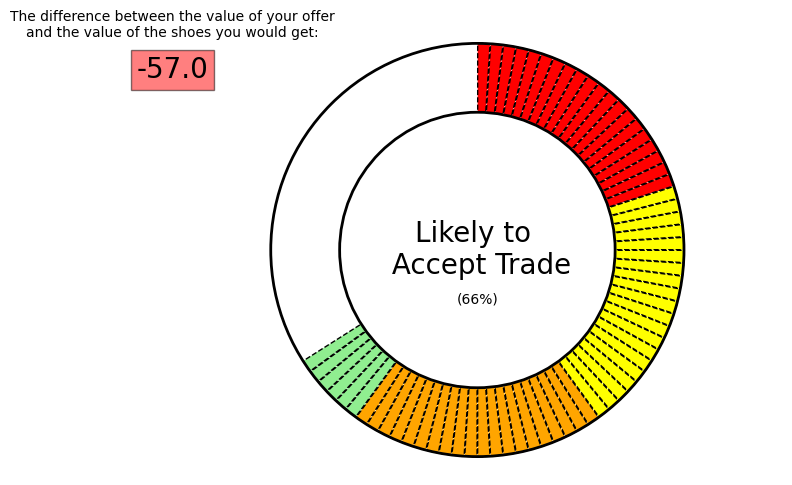

In [ ]:
pie_chart_function(y_prob,test_df_2)

## Updated Offer

In [ ]:
def update_offer(test_df_1,model):
  original_value = test_df_1['trade_val_diff']
  user_input = float(input('Please enter the amount of cash you would like to add to your offer:'))
  test_df_1['trade_val_diff'] += user_input
  test_df_2 = model_dataset(test_df_1)
  y_prob = model_test(test_df_2, model)
  pie_chart_function(y_prob,test_df_2)
  test_df_1['trade_val_diff'] -= user_input
  return

In [ ]:
logreg_ds.coef_

array([[ 0.1303323 , -0.09814101,  0.01655959,  0.09951309,  0.28520782,
         0.03643458, -0.12071428,  0.06176548,  0.03217906]])

Please enter the amount of cash you would like to add to your offer:75


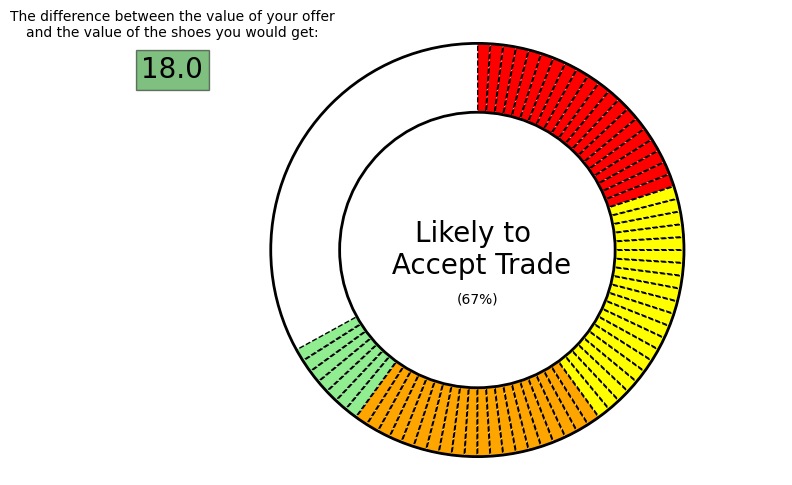

In [ ]:
update_offer(test_df_1,logreg_ds)